In [1]:
import pickle
import os
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import FastICA
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import nibabel as nib
import ants
from scipy.ndimage.morphology import binary_erosion
from scipy.ndimage.morphology import binary_dilation
import cv2
import bigbadbrain as bbb
import scipy
from scipy.interpolate import interp1d
from matplotlib.colors import ListedColormap
from matplotlib.pyplot import cm
import matplotlib.colors as mcolors
import matplotlib
import tqdm
import brainsss

/home/users/brezovec/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning: Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function
  "Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function"


In [3]:
cluster_dir = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20221109_cluster_pca/"

In [6]:
filters_vel = np.load(os.path.join(cluster_dir,'20230202_SC_temporal_filters.npy'))
print(filters_vel.shape)

filters_accel = np.load(os.path.join(cluster_dir,'20230222_SC_temporal_filters_accel.npy'))
print(filters_accel.shape)


(501, 4, 500)
(501, 6, 500)


In [ ]:
# pos/neg refers to velocity, plus/minus refers to acceleration
# behaviors = ['Y_pos_plus', 'Y_pos_minus',
# 			 'Z_pos_plus', 'Z_pos_minus',
# 			 'Z_neg_plus', 'Z_neg_minus']

In [ ]:
accel_key = {0: 'Fwd_Pos_Plus',
             1: 'Fwd_Pos_Minus',
             2: 'Left Turn Increase',
             3: 'Left Turn Decrease',
             4: 'Right Turn Increase',
             5: 'Right Turn Decrease'}

# Generally I expect the increase in velocity to be shifted back in time a bit

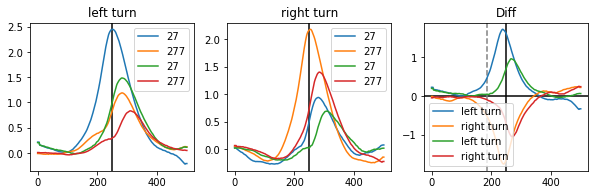

In [21]:
cluster = 27

plt.figure(figsize=(10,6))

plt.subplot(231)
plt.title("left turn")
plt.axvline(250,color='k')
plt.plot(filters_vel[cluster,1,::-1],label=cluster)
plt.plot(filters_vel[cluster+250,1,::-1],label=cluster+250)

plt.plot(filters_accel[cluster,2,::-1],label=cluster)
plt.plot(filters_accel[cluster+250,2,::-1],label=cluster+250)
plt.legend()

plt.subplot(232)
plt.title("right turn")
plt.axvline(250,color='k')
plt.plot(filters_vel[cluster,2,::-1],label=cluster)
plt.plot(filters_vel[cluster+250,2,::-1],label=cluster+250)

plt.plot(filters_accel[cluster,4,::-1],label=cluster)
plt.plot(filters_accel[cluster+250,4,::-1],label=cluster+250)
plt.legend()

plt.subplot(233)
plt.title("Diff")
plt.axhline(0,color='k')
plt.axvline(250,color='k')
plt.axvline(185,color='grey',linestyle='--')
plt.plot(filters_vel[cluster,1,::-1]-filters_vel[cluster+250,1,::-1],label='left turn')
plt.plot((filters_vel[cluster,2,::-1]-filters_vel[cluster+250,2,::-1]),label='right turn')

plt.plot(filters_accel[cluster,2,::-1]-filters_accel[cluster+250,2,::-1],label='left turn')
plt.plot((filters_accel[cluster,4,::-1]-filters_accel[cluster+250,4,::-1]),label='right turn')
plt.legend()

In [24]:
mean_traces_vel = []
mean_traces_accel = []
for cluster in range(250):
    a = filters_vel[cluster,1,::-1]-filters_vel[cluster+250,1,::-1]
    b = (filters_vel[cluster,2,::-1]-filters_vel[cluster+250,2,::-1])*-1
    mean_traces_vel.append((a+b)/2)
    
    c = filters_accel[cluster,2,::-1]-filters_accel[cluster+250,2,::-1]
    d = (filters_accel[cluster,4,::-1]-filters_accel[cluster+250,4,::-1])*-1
    mean_traces_accel.append((c+d)/2)
    
mean_traces_vel = np.asarray(mean_traces_vel)
mean_traces_accel = np.asarray(mean_traces_accel)

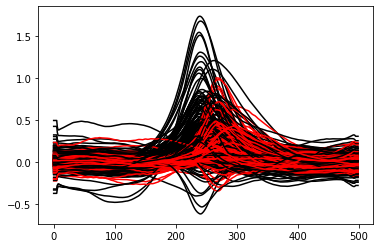

In [28]:
for i in range(250):
    plt.plot(mean_traces_vel[i,:],color='k')
    plt.plot(mean_traces_accel[i,:],color='r')

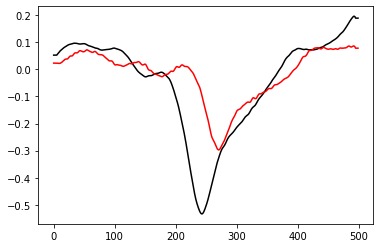

In [89]:
i=247
plt.plot(mean_traces_vel[i,:],color='k')
plt.plot(mean_traces_accel[i,:],color='r')

In [82]:
for i in range(250):
    if np.mean(mean_traces_vel[i,200:300]) < -.1:
        print(i)

0
63
102
110
141
144
247


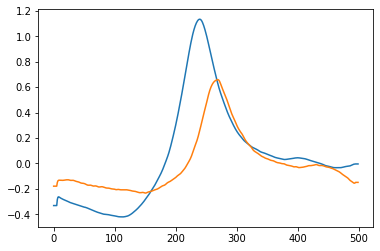

In [29]:
plt.plot(mean_traces_vel[77,:])
plt.plot(mean_traces_accel[77,:])

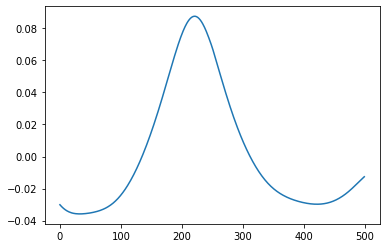

In [30]:
a = mean_traces_vel[77,:]
b = mean_traces_accel[77,:]

out = scipy.signal.correlate(a,b,mode='same')/len(a)
plt.plot(out)

In [32]:
shifts = []
for i in range(250):
    a = mean_traces_vel[i,:]
    b = mean_traces_accel[i,:]
    out = scipy.signal.correlate(a,b,mode='same')/len(a)
    shifts.append(np.argmax(out))

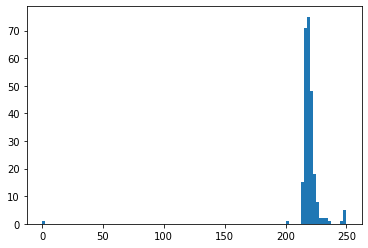

In [36]:
plt.hist(shifts,bins=100);
plt.

In [37]:
np.median(shifts)

218.0

In [38]:
(250-218)*20

640

In [68]:
shifted_accel = np.roll(mean_traces_accel, shift=218-250, axis=1)

scales = []
for i in range(250):
    a = np.mean(np.abs(shifted_accel[i,:]))
    b = np.mean(np.abs(mean_traces_vel[i,:]))
    scales.append(b/a)
np.median(np.nan_to_num(scales))

1.751234432318684

(array([ 1.,  8., 14., 37., 59., 66., 48., 10.,  3.,  3.]),
 array([1.14468442, 1.2639122 , 1.38313998, 1.50236777, 1.62159555,
        1.74082333, 1.86005112, 1.9792789 , 2.09850669, 2.21773447,
        2.33696225]),
 <a list of 10 Patch objects>)

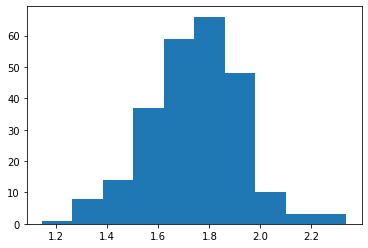

In [65]:
plt.hist(scales)

In [69]:
shifted_scaled_accel = shifted_accel * 1.75

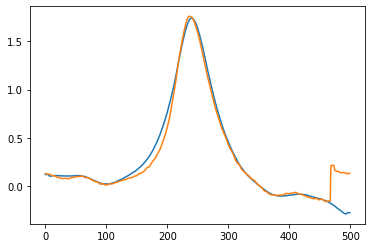

In [71]:
plt.plot(mean_traces_vel[27,:])
plt.plot(shifted_scaled_accel[27,:])

In [72]:
diff = mean_traces_vel-shifted_scaled_accel
diff.shape

(250, 500)

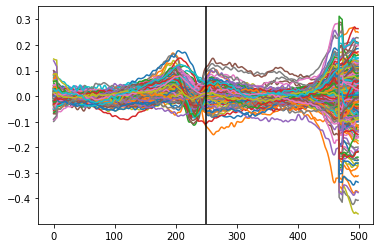

In [74]:
for i in range(250):
    plt.plot(diff[i,:])
plt.axvline(250,color='k')

In [75]:
atlas_clean = brainsss.load_roi_atlas()
explosion_rois = brainsss.load_explosion_groups()
all_rois = brainsss.unnest_roi_groups(explosion_rois)
roi_masks = brainsss.make_single_roi_masks(all_rois, atlas_clean)
roi_contours = brainsss.make_single_roi_contours(roi_masks, atlas_clean)

In [76]:
### lets visualize these high ipsi low contra on brain
file = os.path.join(cluster_dir, 'superclusters_more.npy')
superclusters = np.load(file)
#with 249 there will be clusters 1-250 inclusive (len=250). cluster 140 is background
superclusters_250 = superclusters[:,:,:,249]
# right brain gets +250 to cluster ID so now 500 clusters
superclusters_250[157:,:,:] += 250

In [77]:
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs/20230221_movie_accel_diff'
os.mkdir(save_path)

In [78]:
for k,tp in enumerate(tqdm.tqdm(range(0,500,10))):

    ### color brain by peak time
    brain = np.zeros((314, 146, 91))
    for cluster in range(250):
        ind = np.where(superclusters_250==cluster)
        brain[ind[0],ind[1],ind[2]] = diff[cluster,tp]

    input_canvas = np.ones((500,500,3)) #+.5 #.5 for diverging
    data_to_plot = brain
    vmax = .1
    explosion_map = brainsss.place_roi_groups_on_canvas(explosion_rois,
                                                        roi_masks,
                                                        roi_contours,
                                                        data_to_plot,
                                                        input_canvas,
                                                        vmax=vmax,
                                                        cmap='seismic',
                                                        diverging=True)#'hot')
    
    fig = plt.figure(figsize=(10,10))
    plt.imshow(explosion_map[150:,:])
    plt.axis('off')
    
    fname = os.path.join(save_path, '{0:05d}.png'.format(k))
    plt.savefig(fname,dpi=100,bbox_inches='tight')
    fig.clf()

100%|██████████| 50/50 [06:17<00:00,  7.55s/it]


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>